In [5]:
from skimage.transform import resize
from skimage import util
from tqdm import tqdm
import numpy as np
import functools
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
# from torchsummary import summary
import os
import pathlib
from sklearn.model_selection import train_test_split, StratifiedKFold
import torchio
import nibabel as nib
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import *
import random
from sklearn.metrics import roc_auc_score, precision_score, recall_score
%matplotlib inline

In [6]:
PATH_TO_MRI = '/home/crop_data_resize'
data_dir = pathlib.Path('/data/adni')
behavioral_path = os.path.join('/data/adni', 'unrestricted_hcp_freesurfer.csv')

In [32]:
scale = np.load('/home/normilized_scale.npy')
# scale_without = np.load('/home/scale.npy')

In [38]:
scale[100][0], scale_without[100][0]

(1.0078832604112988, 1.0031449856059147)

In [10]:
bd.head()

,Subject,Gender,Release,FS_InterCranial_Vol,FS_BrainSeg_Vol,FS_BrainSeg_Vol_No_Vent,FS_BrainSeg_Vol_No_Vent_Surf,FS_LCort_GM_Vol,FS_RCort_GM_Vol,FS_TotCort_GM_Vol,...,FS_R_Rostralanteriorcingulate_CurvInd,FS_R_Rostralmiddlefrontal_CurvInd,FS_R_Superiorfrontal_CurvInd,FS_R_Superiorparietal_CurvInd,FS_R_Superiortemporal_CurvInd,FS_R_Supramarginal_CurvInd,FS_R_Frontalpole_CurvInd,FS_R_Temporalpole_CurvInd,FS_R_Transversetemporal_CurvInd,FS_R_Insula_CurvInd
0,100206,M,S900,1.864518e+06,1406924.0,1389007.0,1.386836e+06,304488,305634,610122,...,5.6,34.6,40.1,23.3,15.6,11.9,2.9,3.8,2.8,37.5
1,100307,F,Q1,1.512540e+06,1109710.0,1098854.0,1.097122e+06,240030,243207,483238,...,3.3,29.9,48.8,21.6,18.6,15.0,2.9,5.8,2.0,30.2
2,100408,M,Q3,1.684117e+06,1280171.0,1260943.0,1.259250e+06,260695,265243,525938,...,3.3,25.2,27.5,15.2,13.9,12.3,1.8,7.8,1.9,25.1
3,100610,M,S900,1.816044e+06,1321362.0,1306929.0,1.304569e+06,276506,278002,554508,...,3.0,19.6,20.0,18.6,10.6,10.8,1.2,4.1,1.4,16.6
4,101006,F,S500,1.437868e+06,1053766.0,1038408.0,1.037793e+06,203718,210539,414257,...,2.9,14.7,21.3,13.2,8.7,9.8,1.1,3.0,1.0,18.9


In [17]:
bd = pd.read_csv(behavioral_path)
for item in bd.iterrows():
    print(item)
    print(type(item[1]))
    if item['Gender']=='M':
        print('true')
        break

(0, Subject                                 100206
Gender                                       M
Release                                   S900
FS_InterCranial_Vol                1.86452e+06
FS_BrainSeg_Vol                    1.40692e+06
                                      ...     
FS_R_Supramarginal_CurvInd                11.9
FS_R_Frontalpole_CurvInd                   2.9
FS_R_Temporalpole_CurvInd                  3.8
FS_R_Transversetemporal_CurvInd            2.8
FS_R_Insula_CurvInd                       37.5
Name: 0, Length: 938, dtype: object)
<class 'pandas.core.series.Series'>


TypeError: tuple indices must be integers or slices, not str

In [28]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
# plot_central_cuts(nilearn.image.get_data(img)[np.newaxis,:], title="ex", t = None)
# plot_central_cuts(img_crop, title="ex", t = None)

In [75]:
# bd.set_index('Subject',inplace=True)
i = 211
check = os.listdir('/home/scale_data/')
for item in tqdm(bd.index.values):
    if os.path.exists('/home/scale_data/{}_3T_T1w_MPR1_bet_scale.nii.gz'.format(item)):
        continue
    elif item == int('195041'):
        print('195041')
        continue

    else:
        nii_path = '{}/{}_3T_T1w_MPR1_bet_mask_crop.nii.gz'.format(PATH_TO_MRI, item)
        img = nib.load(nii_path).get_data()

        if bd['Gender'][int(item)]=='M':
            transform = torchio.RandomAffine(
            scales=(scale[i][0], scale[i][0]),
            degrees=0)
    #         transform_without = torchio.RandomAffine(
    #         scales=(scale_without[i][0], scale_without[i][0]),
    #         degrees=0)
    #         print(scale[i][0])
    #         print(scale_without[i][0])
            img = transform(img[np.newaxis,:,:,:])
    #         img_without = transform_without(img[np.newaxis,:,:,:]) 
            img = img.squeeze().astype(int)
            i +=1

    #     elif bd['Gender'][int(item)]=='F':
    #         print('F')

        nib.save(nib.Nifti1Image(img, affine = np.eye(4)), '/home/scale_data/{}_3T_T1w_MPR1_bet_scale.nii.gz'.format(item))
    

  0%|          | 0/1113 [00:00<?, ?it/s]/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  del sys.path[0]


195041


100%|██████████| 1113/1113 [28:56<00:00,  1.56s/it]


In [65]:
print(i)

211


In [76]:
len(os.listdir('/home/scale_data/'))

1112

In [79]:
!nvidia-smi

Wed Apr  7 10:34:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:05:00.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |  11915MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:08:00.0 Off |                    0 |
| N/A   38C    P0    42W / 250W |  14326MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


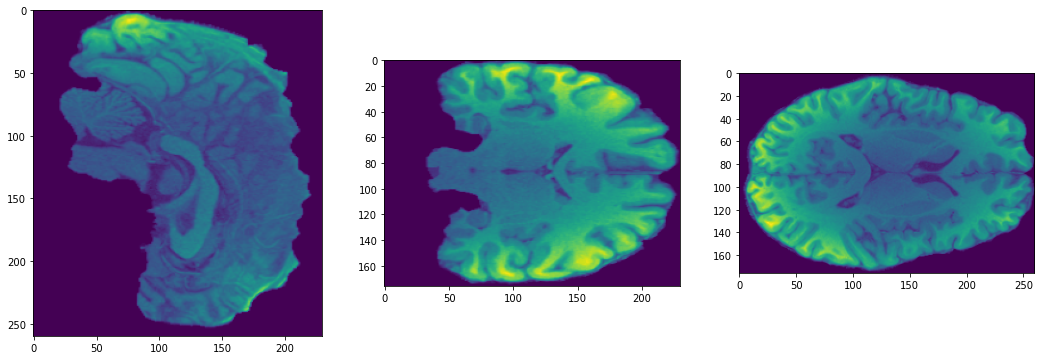

In [51]:
#check
nii_path = '/home/scale_data/100206_3T_T1w_MPR1_bet_scale.nii.gz'
img = nib.load(nii_path).get_data()
plot_central_cuts(img[np.newaxis,:,:,:])

In [53]:
len(os.listdir('/home/crop_data_resize'))

1112

In [56]:
os.path.exists('/home/crop_data_resize/195041_3T_T1w_MPR1_bet_mask_crop.nii.gz')

False

In [57]:
len(bd)

1113

In [63]:
files =  os.listdir('/home/crop_data_resize')
for each in  files:
#     print(each)
    if '195041' in each:
        print(each)
    elif '111514' in each:
        print(each)

111514_3T_T1w_MPR1_bet_mask_crop.nii.gz


In [64]:
bd

,Gender,Release,FS_InterCranial_Vol,FS_BrainSeg_Vol,FS_BrainSeg_Vol_No_Vent,FS_BrainSeg_Vol_No_Vent_Surf,FS_LCort_GM_Vol,FS_RCort_GM_Vol,FS_TotCort_GM_Vol,FS_SubCort_GM_Vol,...,FS_R_Rostralanteriorcingulate_CurvInd,FS_R_Rostralmiddlefrontal_CurvInd,FS_R_Superiorfrontal_CurvInd,FS_R_Superiorparietal_CurvInd,FS_R_Superiortemporal_CurvInd,FS_R_Supramarginal_CurvInd,FS_R_Frontalpole_CurvInd,FS_R_Temporalpole_CurvInd,FS_R_Transversetemporal_CurvInd,FS_R_Insula_CurvInd
Subject,,,,,,,,,,,,,,,,,,,,,
100206,M,S900,1.864518e+06,1406924.0,1389007.0,1.386836e+06,304488,305634,610122,70240,...,5.6,34.6,40.1,23.3,15.6,11.9,2.9,3.8,2.8,37.5
100307,F,Q1,1.512540e+06,1109710.0,1098854.0,1.097122e+06,240030,243207,483238,56623,...,3.3,29.9,48.8,21.6,18.6,15.0,2.9,5.8,2.0,30.2
100408,M,Q3,1.684117e+06,1280171.0,1260943.0,1.259250e+06,260695,265243,525938,63869,...,3.3,25.2,27.5,15.2,13.9,12.3,1.8,7.8,1.9,25.1
100610,M,S900,1.816044e+06,1321362.0,1306929.0,1.304569e+06,276506,278002,554508,74869,...,3.0,19.6,20.0,18.6,10.6,10.8,1.2,4.1,1.4,16.6
101006,F,S500,1.437868e+06,1053766.0,1038408.0,1.037793e+06,203718,210539,414257,58813,...,2.9,14.7,21.3,13.2,8.7,9.8,1.1,3.0,1.0,18.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992774,M,Q2,1.519017e+06,1136193.0,1115715.0,1.113862e+06,232242,235740,467982,57546,...,3.4,16.2,18.7,11.5,8.3,8.6,0.6,2.6,0.9,16.6
993675,F,S900,1.408199e+06,1037401.0,1020944.0,1.019593e+06,233533,246215,479748,54442,...,2.3,15.6,23.5,16.4,6.4,9.1,1.1,4.0,0.9,17.4
994273,M,S500,1.738013e+06,1234076.0,1217881.0,1.216379e+06,258246,268631,526877,63592,...,5.8,24.2,33.8,20.5,16.6,15.9,1.2,4.7,3.4,73.7


In [ ]:
for item in tqdm(bd.index.values)